# Resume Parsing

Spacy!!

pip install spacy or pip install -U 'spacy[cuda-autodetect]'

python -m spacy download en_core_web_sm #trained using cnn

python -m spacy download en_core_web_md #has word embedding (gloVe); trained using cnn

python -m spacy download en_core_web_trf #everything is trained using transformer

cmd.exe /k "C:\ProgramData\anaconda3\Scripts\activate.bat" nlp-env


## 1. Load data

In [4]:
import pandas as pd
import numpy as np

df_resume = pd.read_csv("app/datasets/resume.csv")

In [5]:
df_resume.Category.unique()

array(['HR', 'DESIGNER', 'INFORMATION-TECHNOLOGY', 'TEACHER', 'ADVOCATE',
       'BUSINESS-DEVELOPMENT', 'HEALTHCARE', 'FITNESS', 'AGRICULTURE',
       'BPO', 'SALES', 'CONSULTANT', 'DIGITAL-MEDIA', 'AUTOMOBILE',
       'CHEF', 'FINANCE', 'APPAREL', 'ENGINEERING', 'ACCOUNTANT',
       'CONSTRUCTION', 'PUBLIC-RELATIONS', 'BANKING', 'ARTS', 'AVIATION'],
      dtype=object)

In [6]:
df_resume.shape

(2484, 4)

In [7]:
df_resume = df_resume.reindex(np.random.permutation(df_resume.index))
df_resume = df_resume.copy().iloc[:1000, ]
df_resume.shape

(1000, 4)

## 2. Load skill data

If we define patterns for all the skill, we gonna be too tired.

So spacy knows that, so it allows you to give you a list of words, then it will automatically create pattern.

In [8]:
import spacy

nlp = spacy.load('en_core_web_md')
skill_path = 'app/datasets/skills.jsonl'

In [9]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [10]:
doc = nlp("Chaky loves ajax.")
doc.ents

(Chaky, ajax)

## 3. Let's try to extract skills from this resume.csv

In [11]:
df_resume.head()

,ID,Resume_str,Resume_html,Category
1291,59011090,SOCIAL MEDIA COORDINATOR Summar...,"<div class=""fontsize fontface vmargins hmargin...",DIGITAL-MEDIA
1005,71772815,SALES Summary OFFICE & CUSTO...,"<div class=""fontsize fontface vmargins hmargin...",SALES
747,23110214,DIRECTOR OF APPLICATIONS Prof...,"<div class=""fontsize fontface vmargins hmargin...",HEALTHCARE
1013,15918496,SALES Summary Focused and d...,"<div class=""fontsize fontface vmargins hmargin...",SALES
2254,14626780,GRANTS MANAGER Summary ...,"<div class=""fontsize fontface vmargins hmargin...",BANKING


In [12]:
#clean our data
from spacy.lang.en.stop_words import STOP_WORDS

def preprocessing(sentence):
    stopwords    = list(STOP_WORDS)
    doc          = nlp(sentence)
    clean_tokens = []
    
    for token in doc:
        if token.text not in stopwords and token.pos_ != 'PUNCT' and token.pos_ != 'SYM' and \
            token.pos_ != 'SPACE':
                clean_tokens.append(token.lemma_.lower().strip())
                
    return " ".join(clean_tokens)

In [13]:
random_resume = df_resume.Resume_str.iloc[5]
random_resume[:300]

'         DIRECTOR OF INFORMATION TECHNOLOGY       Summary    IT Director/Manager with extensive experience in network operations, leveraging expertise in organization growth and problem solving. Driven, professional and detailed-oriented with the proven ability to plan, design and implement technica'

In [14]:
preprocessing(random_resume[:300])

'director of information technology summary it director manager extensive experience network operation leverage expertise organization growth problem solving drive professional detail oriented prove ability plan design implement technica'

In [15]:
for i, row in df_resume.iterrows():
    clean_text = preprocessing(row.Resume_str)
    df_resume.at[i, 'Clean_resume'] = clean_text

In [16]:
df_resume.head()

,ID,Resume_str,Resume_html,Category,Clean_resume
1291,59011090,SOCIAL MEDIA COORDINATOR Summar...,"<div class=""fontsize fontface vmargins hmargin...",DIGITAL-MEDIA,social media coordinator summary to secure pos...
1005,71772815,SALES Summary OFFICE & CUSTO...,"<div class=""fontsize fontface vmargins hmargin...",SALES,sale summary office & customer service experie...
747,23110214,DIRECTOR OF APPLICATIONS Prof...,"<div class=""fontsize fontface vmargins hmargin...",HEALTHCARE,director of application profile accomplished h...
1013,15918496,SALES Summary Focused and d...,"<div class=""fontsize fontface vmargins hmargin...",SALES,sale summary focused dedicated insurance profe...
2254,14626780,GRANTS MANAGER Summary ...,"<div class=""fontsize fontface vmargins hmargin...",BANKING,grant manager summary finance professional suc...


## 4. Let's really extract skills!!

In [17]:
def get_skills(text):
    
    doc = nlp(text)
    
    skills = []
    
    for ent in doc.ents:
        if ent.label_ == 'SKILL':
            skills.append(ent.text)
            
    return skills

def unique_skills(x):
    return list(set(x))

In [18]:
############
def get_entities(resume):
    
    doc = nlp(resume)

    entities={}
    
    for entity in doc.ents:
        if entity.label_ in entities:
            entities[entity.label_].append(entity.text)
        else:
            entities[entity.label_] = [entity.text]
    for ent_type in entities.keys():
        entities[ent_type]=', '.join(unique_entities(entities[ent_type]))
    return entities

def unique_entities(x):
    return list(set(x))

In [19]:
df_resume['Skills'] = df_resume.Clean_resume.apply(get_skills)
df_resume['Skills'] = df_resume.Skills.apply(unique_skills)

In [20]:
df_resume.Skills.iloc[0]

['twitter',
 'communications',
 'design',
 'mailchimp',
 'marketing',
 'medium',
 'languages',
 'advertising',
 'schedule',
 'release',
 'email marketing',
 'business',
 'google']

## 5. Visualization

Which skills is most important in information management?

In [21]:
# set(df_resume.Category)

In [22]:
category = 'INFORMATION-TECHNOLOGY'
cond = df_resume.Category == category

df_resume_it = df_resume[cond]
df_resume_it.shape

(53, 6)

In [23]:
all_skills = np.concatenate(df_resume_it.Skills.values)

In [24]:
from collections import Counter, OrderedDict

counting = Counter(all_skills)
counting = OrderedDict(counting.most_common(10))

In [25]:
counting

OrderedDict([('support', 49),
             ('software', 46),
             ('business', 43),
             ('design', 40),
             ('server', 36),
             ('security', 36),
             ('windows', 34),
             ('database', 33),
             ('project management', 27),
             ('documentation', 24)])

<BarContainer object of 10 artists>

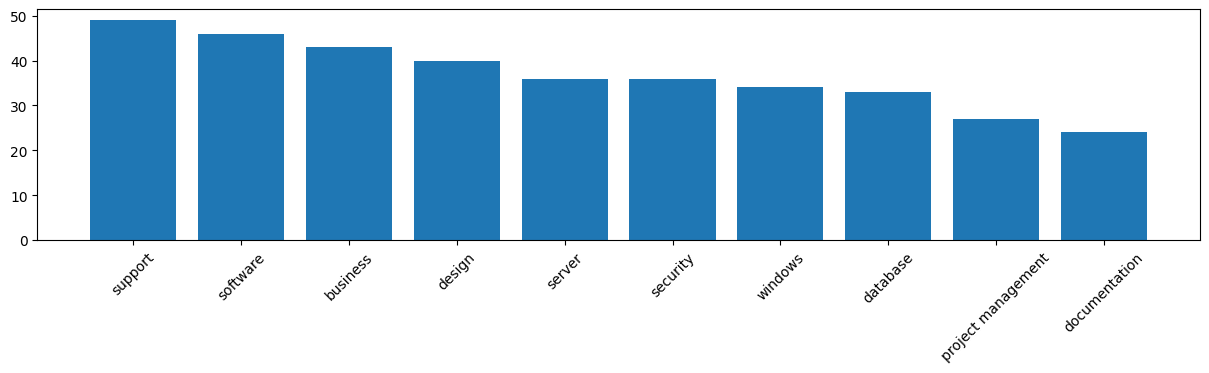

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
plt.xticks(rotation=45)

plt.bar(counting.keys(), counting.values())

## 6. Added Spacy classes for Education and Skills from the resume

In [53]:
import spacy
from spacy.matcher import Matcher
from spacy.tokens import Span
import pandas as pd
import pdfplumber

# Load English tokenizer, tagger, parser, NER, and word vectors
nlp = spacy.load("en_core_web_sm")

# Define patterns for matching skill phrases
skill_patterns = [
    [{"LOWER": {"IN": ["python", "java", "c++"]}}],
    [{"LOWER": "data"}, {"LOWER": "analysis"}],
    [{"LOWER": "machine"}, {"LOWER": "learning"}],
    # Add more patterns for other skills as needed
]

# Function to add custom skill entities to the document
@spacy.Language.component("add_skill_entities")
def add_skill_entities(doc):
    matcher = Matcher(nlp.vocab)
    matcher.add("SKILL", skill_patterns)
    matches = matcher(doc)
    spans = []
    for match_id, start, end in matches:
        span = Span(doc, start, end, label="SKILL")
        spans.append(span)
    doc.ents = list(doc.ents) + spans
    return doc

# Function to extract skills from text
def get_skills(text):
    doc = nlp(text)
    skills = []
    for ent in doc.ents:
        if ent.label_ == 'SKILL':
            skills.append(ent.text)
    return list(set(skills))

# Function to extract education information from text
def get_education(text):
    doc = nlp(text)
    education = []
    for ent in doc.ents:
        if ent.label_ == 'EDUCATION':
            education.append(ent.text)
    return list(set(education))

# Function to extract text from a PDF file
def extract_text_from_pdf(pdf_file):
    with pdfplumber.open(pdf_file) as pdf:
        resume_text = ""
        for page in pdf.pages:
            resume_text += page.extract_text()
    return resume_text

# Example usage:
def process_resume_pdf(pdf_file):
    resume_text = extract_text_from_pdf(pdf_file)
    skills = get_skills(resume_text)
    education = get_education(resume_text)
    return skills, education

# Example usage with a PDF file named "resume.pdf"
skills, education = process_resume_pdf("app/datasets/cvsum.pdf")
print("Extracted Skills:", skills)
print("Extracted Education:", education)


Extracted Skills: []
Extracted Education: []


## Implement additional features or improvements inspired by spaCy’s capabilities in natural language
processing.

In [55]:
import spacy
from spacy.tokens import Doc, Span

# Load English tokenizer, tagger, parser, NER, and word vectors
nlp = spacy.load("en_core_web_sm")

# Define a custom skill entity linking function
@spacy.Language.component("link_skills")
def link_skills(doc):
    linked_entities = []
    for ent in doc.ents:
        if ent.label_ == 'SKILL':
            # Perform entity linking for each skill entity
            linked_entity = custom_skill_linking_function(ent.text)
            linked_entities.append((ent.start_char, ent.end_char, linked_entity))
    # Add custom entity extensions to the doc
    doc._.linked_entities = linked_entities
    return doc

# Define a custom function to perform entity linking for skills
def custom_skill_linking_function(skill_text):
    
    return {"skill": skill_text, "description": "Placeholder description for skill: " + skill_text}

# Add the custom component to the pipeline
nlp.add_pipe("link_skills", name="custom_entity_linking", last=True)

# Register the linked_entities extension attribute
Doc.set_extension("linked_entities", default=[], force=True)

# Example usage:
text = "I am proficient in Python and Java."
doc = nlp(text)

# Access the linked entities from the doc
for start, end, linked_entity in doc._.linked_entities:
    print("Entity:", doc[start:end], "Linked Entity:", linked_entity)


## 8. Let's load the PDF - add some realism

In [36]:
from PyPDF2 import PdfReader

reader = PdfReader("app/datasets/cvsum.pdf")
page = reader.pages[0]
text = page.extract_text()

In [40]:

text = preprocessing(text)


In [41]:

doc = nlp(text)

In [42]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style='ent', options=options)